# BCI-Motor imagery Data Preprocessing

- Import data and check stimulus events

In [2]:
import mne
import numpy as np
from mne.datasets import eegbci
from mne.channels import make_standard_montage

raw_edf = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\class3_pipo_edf.edf",preload = True)
eegbci.standardize(raw_edf)  # set channel names
montage = make_standard_montage("standard_1005")
raw_edf.set_montage(montage)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\class3_pipo_edf.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 107749  =      0.000 ...   430.996 secs...


<RawEDF | class3_pipo_edf.edf, 8 x 107750 (431.0 s), ~6.6 MB, data loaded>

Using matplotlib as 2D backend.


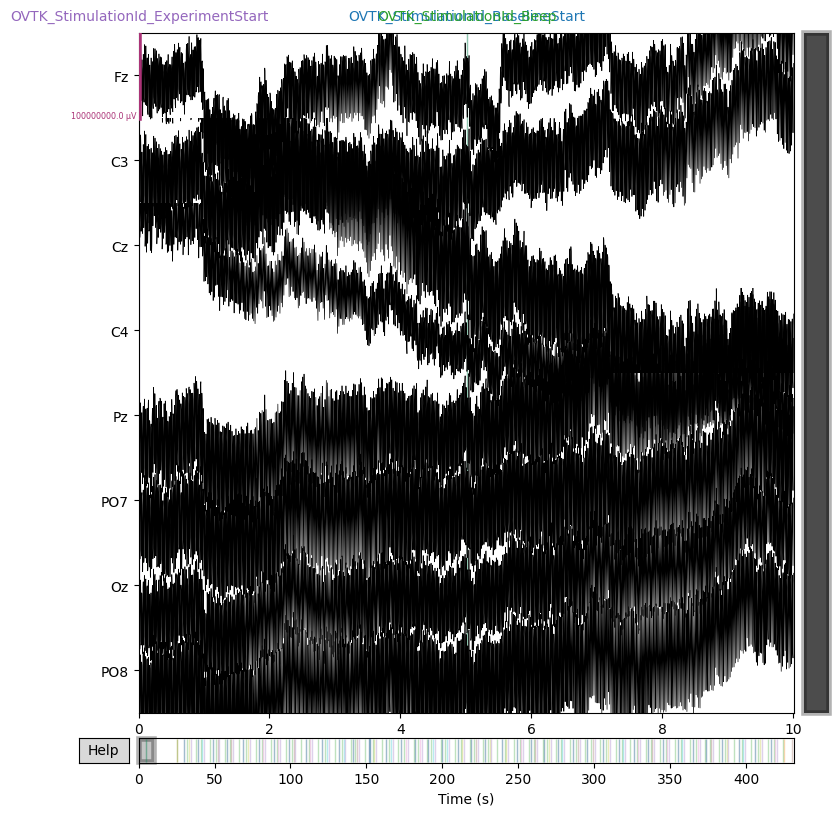

...


In [3]:
raw_edf.plot(
    duration=10, 
    start=0.0, 
    scalings=50, # You may edit scalings value later
    )
print("...")

In [4]:
max(raw_edf[6][0][0])

95823.09

# Feature Extraction

- MRCP , LF-ASD

In [5]:
import sys
import matplotlib.pyplot as plt
sys.path.append("..")
from tsfilt import (
    BoxFilter, GaussianFilter, BilateralFilter, IdenticalFilter, NonLocalMeanFilter
)

In [6]:
eeg1 = raw_edf.copy().filter(l_freq=1.0, h_freq=3.0, method = 'iir', iir_params= {"order": 12, "ftype":'butter'})
eeg1 = eeg1.copy().set_eeg_reference(ref_channels="average")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 48 (effective, after forward-backward)
- Cutoffs at 1.00, 3.00 Hz: -6.02, -6.02 dB



c:\Python311\Lib\site-packages\scipy\signal\_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [7]:
max(eeg1[0][0][0])

294.9128006203801

In [8]:
eeg1= eeg1.pick_channels(['C3','Cz','C4'])
events, event_dict = mne.events_from_annotations(eeg1)
epochs = mne.Epochs(eeg1, events, 
        tmin=-1.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=3.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop'
    )

Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_Train']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
205 matching events found
Setting baseline interval to [-1.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 205 events and 1126 original time points ...
2 bad epochs dropped


In [9]:
def display(x, x_filt, title):
    plt.figure(figsize=(20, 3))
    plt.plot(x, "-", label="original")
    plt.plot(x_filt, "-", label="filtered")
    plt.title(title)
    plt.legend()
    plt.show()

WIN_SIZE = 1125
Select_channel = 3
filters = {
    # "box": BoxFilter(WIN_SIZE),
    "gaussian": GaussianFilter(WIN_SIZE, sigma_d=20),
    # "bilateral": BilateralFilter(WIN_SIZE, sigma_d=15, sigma_i=7.5),
    # "non local mean": NonLocalMeanFilter(WIN_SIZE)
}
# print(filters.items())
left_epochs = epochs['OVTK_GDF_Left']
right_epochs = epochs['OVTK_GDF_Right']
up_epochs = epochs['OVTK_GDF_Up']
for filter_name,filt in filters.items():
    for j in range(0,Select_channel):
        for i in range(0,len(epochs['OVTK_GDF_Left'])):
            left_filt = filt.fit_transform(left_epochs.get_data()[i][j])
            left_epochs._data[i][j] = left_filt
            right_filt = filt.fit_transform(right_epochs.get_data()[i][j])
            right_epochs._data[i][j] = right_filt
            up_filt = filt.fit_transform(up_epochs.get_data()[i][j])
            up_epochs._data[i][j] = up_filt

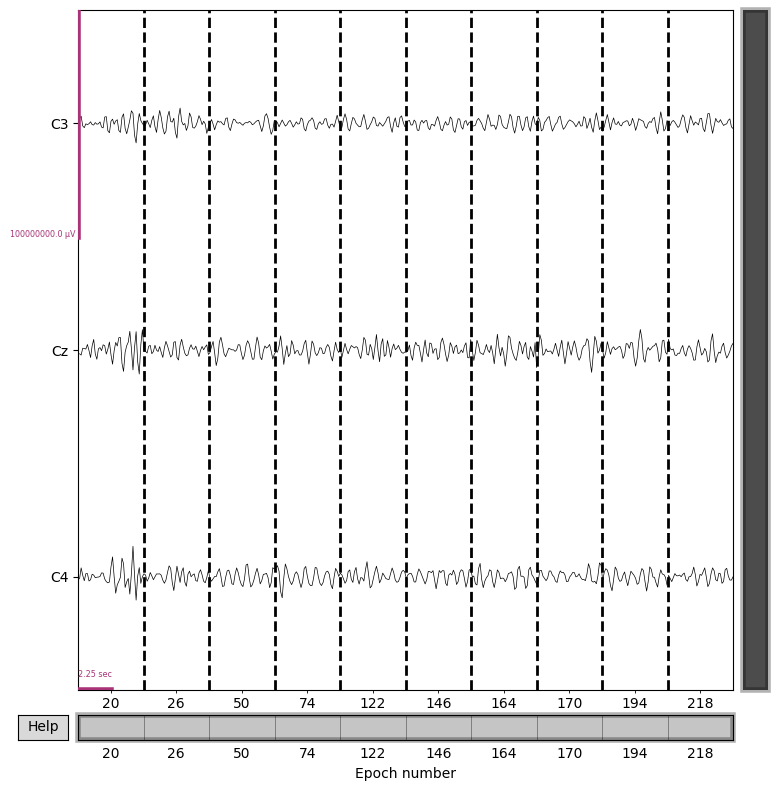

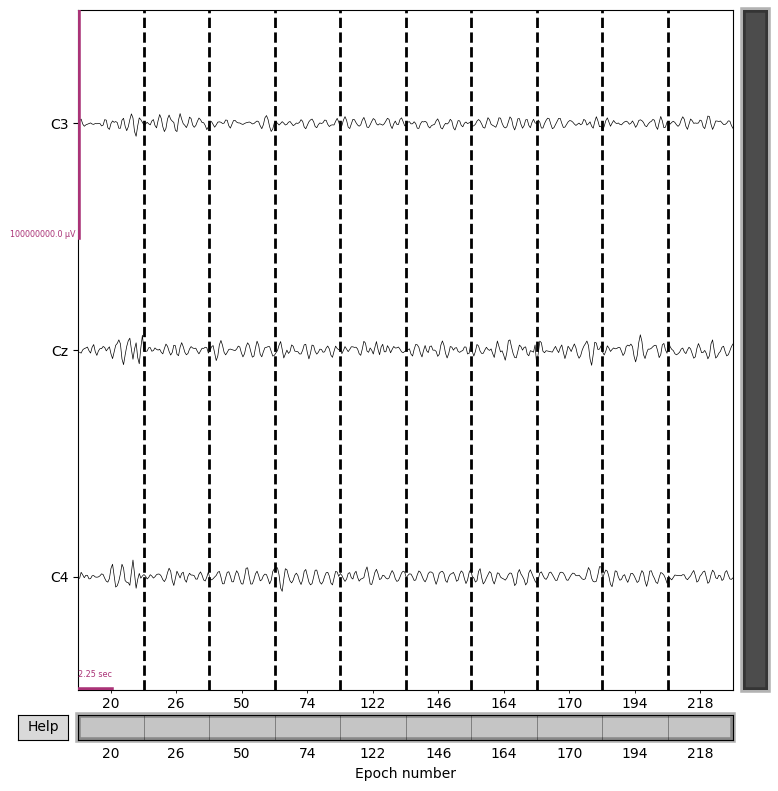

In [10]:
epochs['OVTK_GDF_Left'].plot(
    scalings=50, # You may edit scalings value later
)
left_epochs.plot(
    scalings=50, # You may edit scalings value later
)
left = left_epochs['OVTK_GDF_Left'].average()

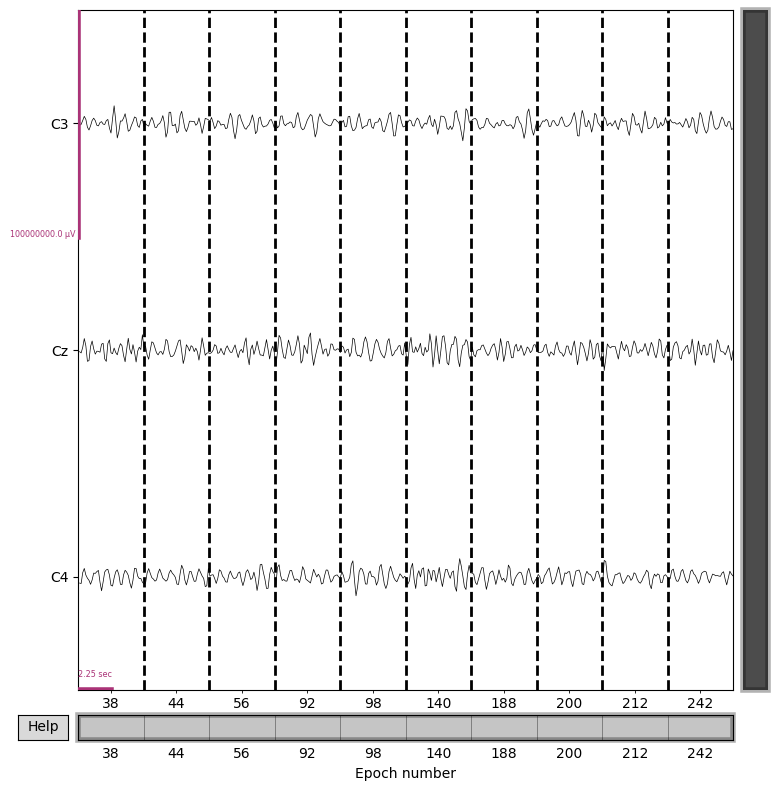

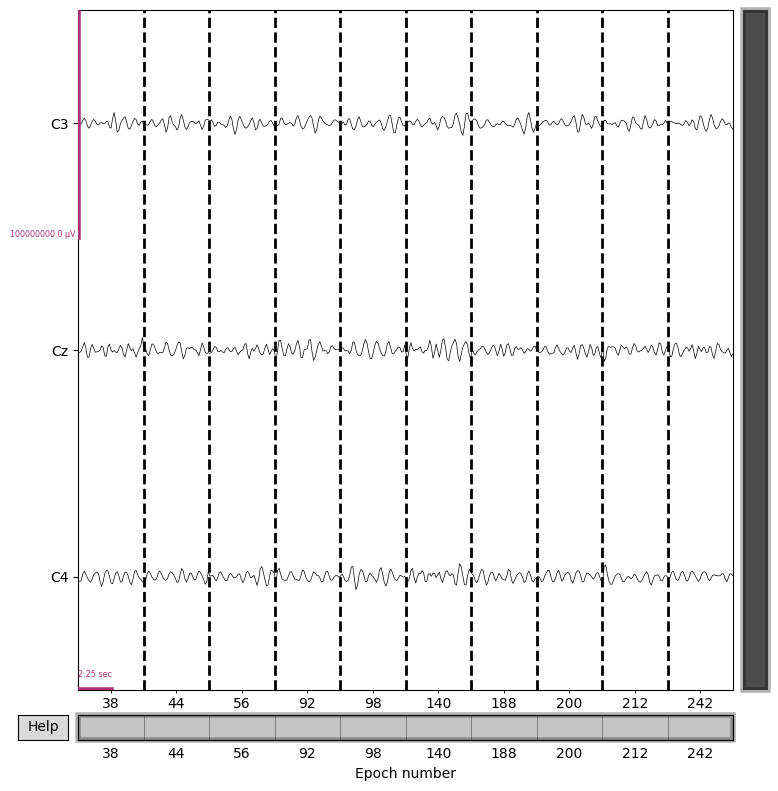

In [11]:
epochs['OVTK_GDF_Right'].plot(
    scalings=50, # You may edit scalings value later
)
right_epochs.plot(
    scalings=50, # You may edit scalings value later
)
right = right_epochs['OVTK_GDF_Right'].average()

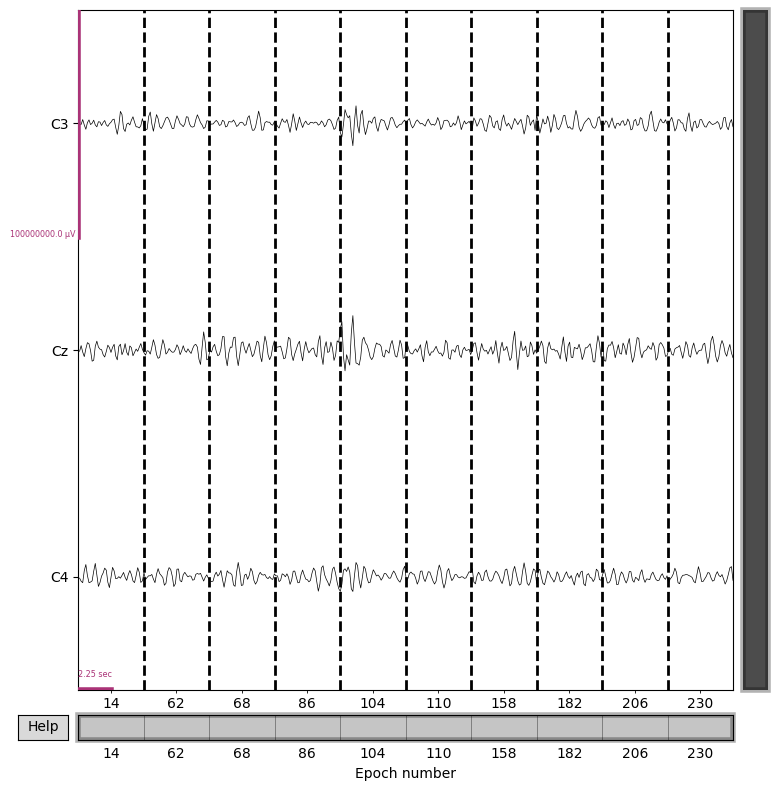

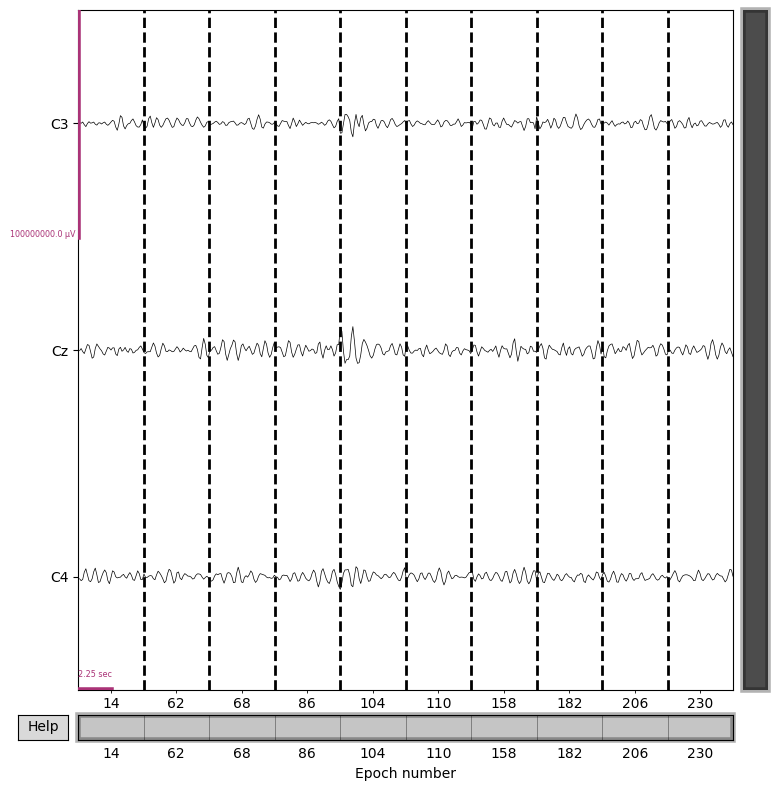

In [12]:
epochs['OVTK_GDF_Up'].plot(
    scalings=50, # You may edit scalings value later
)
up_epochs.plot(
    scalings=50, # You may edit scalings value later
)
up = up_epochs['OVTK_GDF_Up'].average()

Need more than one channel to make topography for eeg. Disabling interactivity.


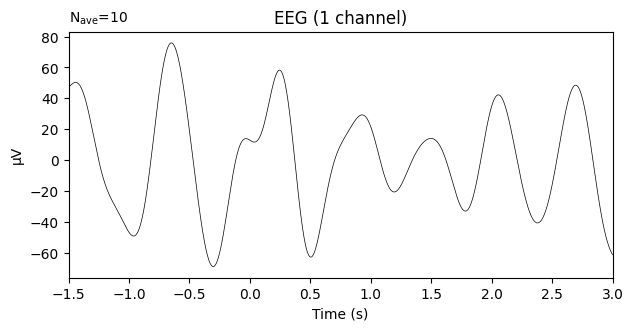

Need more than one channel to make topography for eeg. Disabling interactivity.


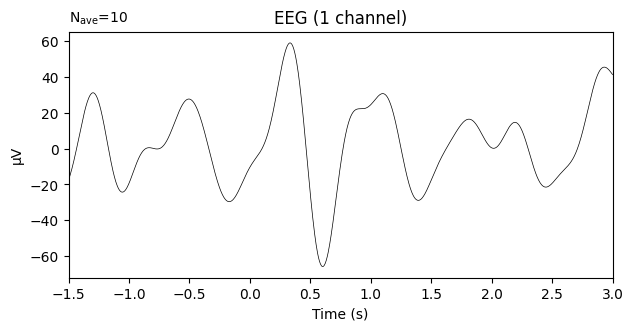

Need more than one channel to make topography for eeg. Disabling interactivity.


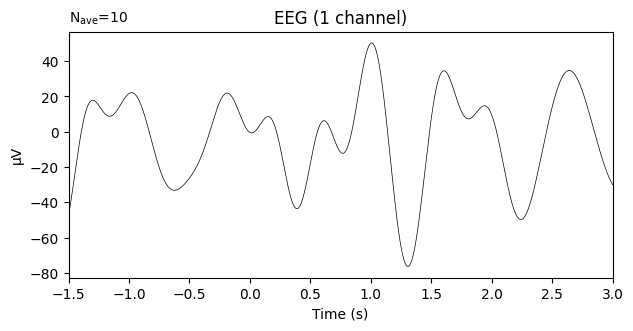

...


In [13]:
up.plot(scalings=50, picks="Cz")
left.plot(scalings=50, picks="C4")
right.plot(scalings=50, picks="C3")
print("...")

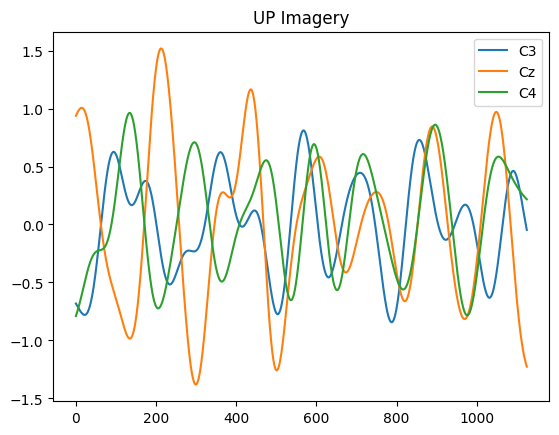

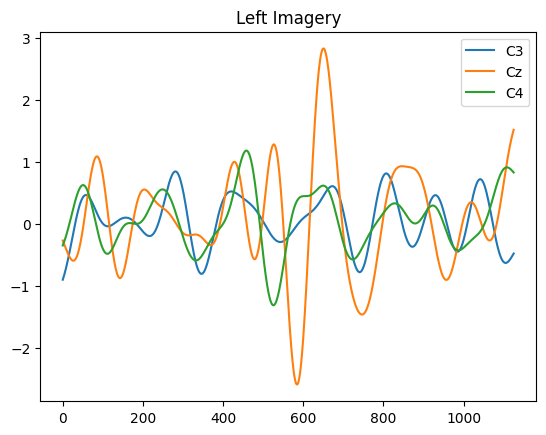

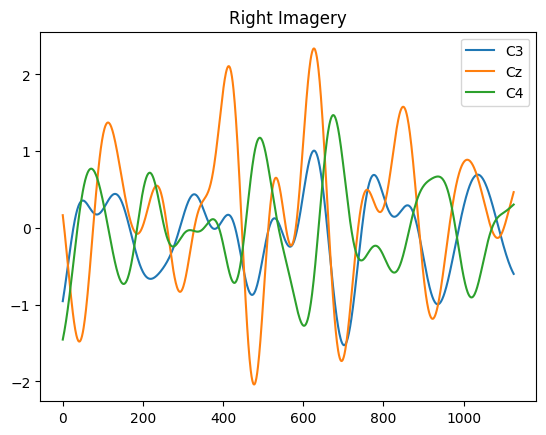

In [14]:
plt.plot(up.get_data()[0],label='C3')
plt.plot(up.get_data()[1],label='Cz')
plt.plot(up.get_data()[2],label='C4')
plt.title('UP Imagery')
plt.legend()
plt.show()

plt.plot(left.get_data()[0],label='C3')
plt.plot(left.get_data()[1],label='Cz')
plt.plot(left.get_data()[2],label='C4')
plt.title('Left Imagery')
plt.legend()
plt.show()

plt.plot(right.get_data()[0],label='C3')
plt.plot(right.get_data()[1],label='Cz')
plt.plot(right.get_data()[2],label='C4')
plt.title('Right Imagery')
plt.legend()
plt.show()

- ERD/ERS

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

In [16]:
eeg2 = raw_edf.copy().filter(l_freq=1.0, h_freq=35.0, method = 'iir', iir_params= {"order": 12, "ftype":'butter'})
eeg2 = eeg2.copy().set_eeg_reference(ref_channels="average")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 48 (effective, after forward-backward)
- Cutoffs at 2.00, 35.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [17]:
events, _ = mne.events_from_annotations(eeg2, event_id=dict(OVTK_GDF_Left=1, OVTK_GDF_Right=2, OVTK_GDF_Up=3))
event_ids = dict(OVTK_GDF_Left=1, OVTK_GDF_Right=2, OVTK_GDF_Up=3)
erds_epochs = mne.Epochs(eeg2, events,event_ids,
        tmin = -1.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax = 4.0,    # final timestamp (10 means set epoch duration 10 second)
        picks=("C3", "Cz", "C4"),
        preload = True,
        event_repeated='drop'
    )

Used Annotations descriptions: ['OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Up']
Not setting metadata
30 matching events found
Setting baseline interval to [-1.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1376 original time points ...
0 bad epochs dropped


In [18]:
freqs = np.arange(1, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 2.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.833113
stat_fun(H1): min=-12.163171 max=4.212180
Running initial clustering …
Found 78 clusters


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
C:\Users\pipo_\AppData\Local\Temp\ipykernel_24956\2626864374.py:10: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.EpochsTFR'>.tmax (3.996 sec)
  tfr.crop(-1, 4).apply_baseline(baseline, mode="percent")
C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 99/99 [00:00<00:00,  387.54it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations


Using a threshold of -1.833113
stat_fun(H1): min=-12.163171 max=4.212180
Running initial clustering …
Found 55 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  386.44it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  362.05it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied


Using a threshold of 1.833113
stat_fun(H1): min=-20.004672 max=3.958521
Running initial clustering …
Found 53 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  396.17it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.833113
stat_fun(H1): min=-20.004672 max=3.958521
Running initial clustering …
Found 51 clusters



100%|██████████| Permuting : 99/99 [00:00<00:00,  396.20it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  394.32it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.833113


stat_fun(H1): min=-18.419200 max=4.126485
Running initial clustering …
Found 41 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  418.51it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.833113


stat_fun(H1): min=-18.419200 max=4.126485
Running initial clustering …
Found 69 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  420.07it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  408.45it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied


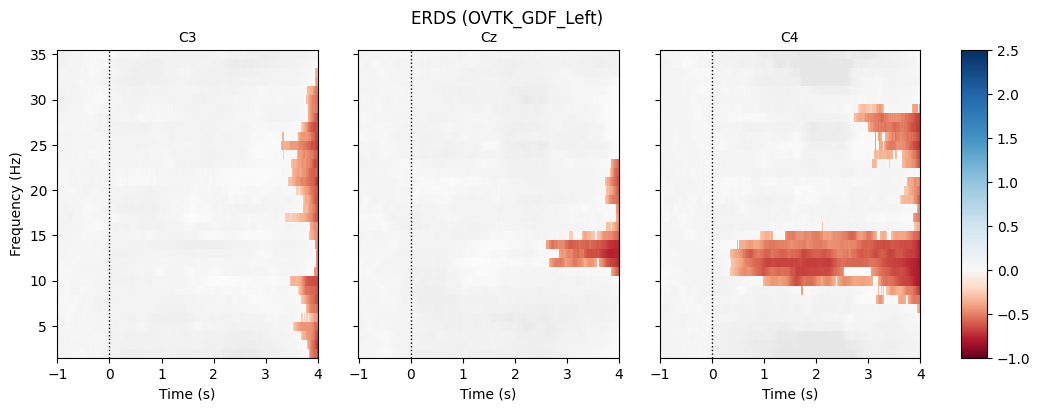

Using a threshold of 1.833113
stat_fun(H1): min=-14.308350 max=3.793588
Running initial clustering …
Found 42 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  407.20it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.833113
stat_fun(H1): min=-14.308350 max=3.793588
Running initial clustering …
Found 53 clusters



100%|██████████| Permuting : 99/99 [00:00<00:00,  410.75it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  416.10it/s]

Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  413.25it/s]

Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations


No baseline correction applied
Using a threshold of 1.833113
stat_fun(H1): min=-14.546648 max=4.594369
Running initial clustering …
Found 64 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  399.59it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  413.69it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.833113
stat_fun(H1): min=-14.546648 max=4.594369
Running initial clustering …
Found 44 clusters



100%|██████████| Permuting : 99/99 [00:00<00:00,  408.34it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  369.30it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


No baseline correction applied
Using a threshold of 1.833113
stat_fun(H1): min=-12.008400 max=4.989175
Running initial clustering …
Found 84 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  424.40it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  420.72it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.833113


stat_fun(H1): min=-12.008400 max=4.989175
Running initial clustering …
Found 48 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  418.45it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations


No baseline correction applied


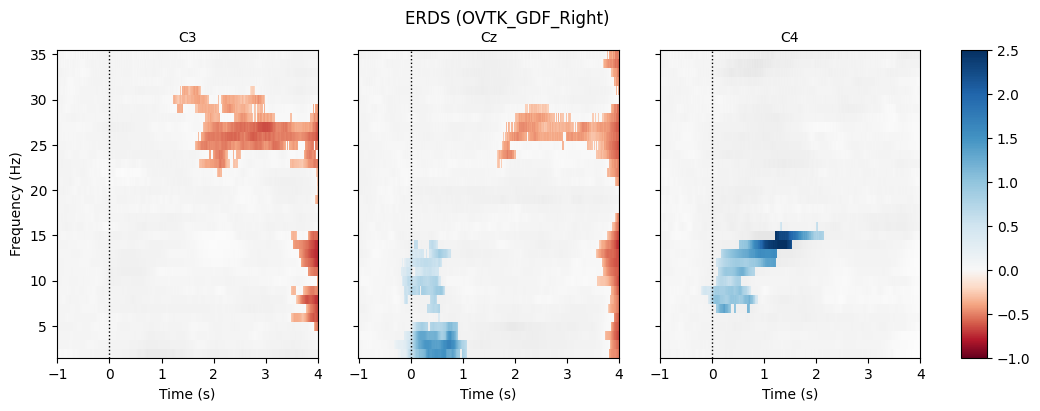

Using a threshold of 1.833113
stat_fun(H1): min=-9.260445 max=3.868141
Running initial clustering …
Found 25 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  394.49it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations


Using a threshold of -1.833113
stat_fun(H1): min=-9.260445 max=3.868141
Running initial clustering …
Found 85 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  389.89it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.833113


stat_fun(H1): min=-11.178719 max=4.812210
Running initial clustering …
Found 67 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  391.61it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  413.78it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


Using a threshold of -1.833113
stat_fun(H1): min=-11.178719 max=4.812210
Running initial clustering …
Found 41 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  419.31it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


Using a threshold of 1.833113
stat_fun(H1): min=-11.631620 max=5.344333
Running initial clustering …
Found 57 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  414.54it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  418.91it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.833113
stat_fun(H1): min=-11.631620 max=5.344333
Running initial clustering …
Found 83 clusters



100%|██████████| Permuting : 99/99 [00:00<00:00,  398.76it/s]


Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


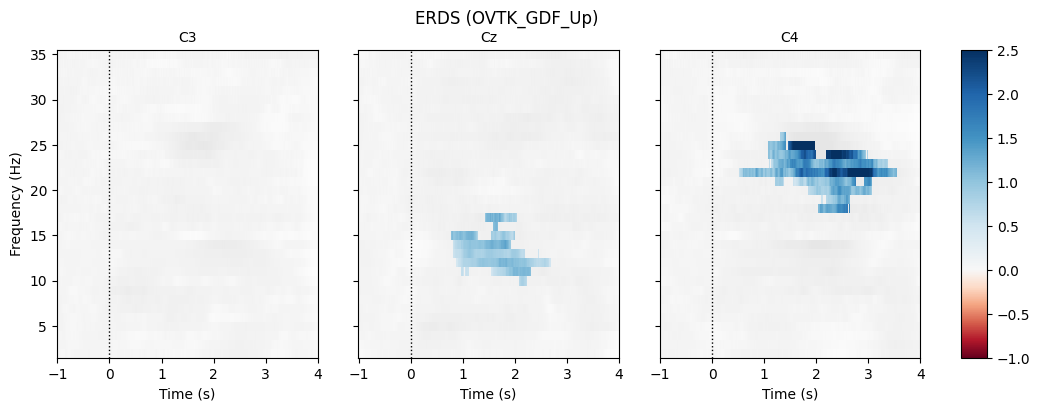

In [19]:
tfr = tfr_multitaper(
    erds_epochs,
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(-1, 4).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


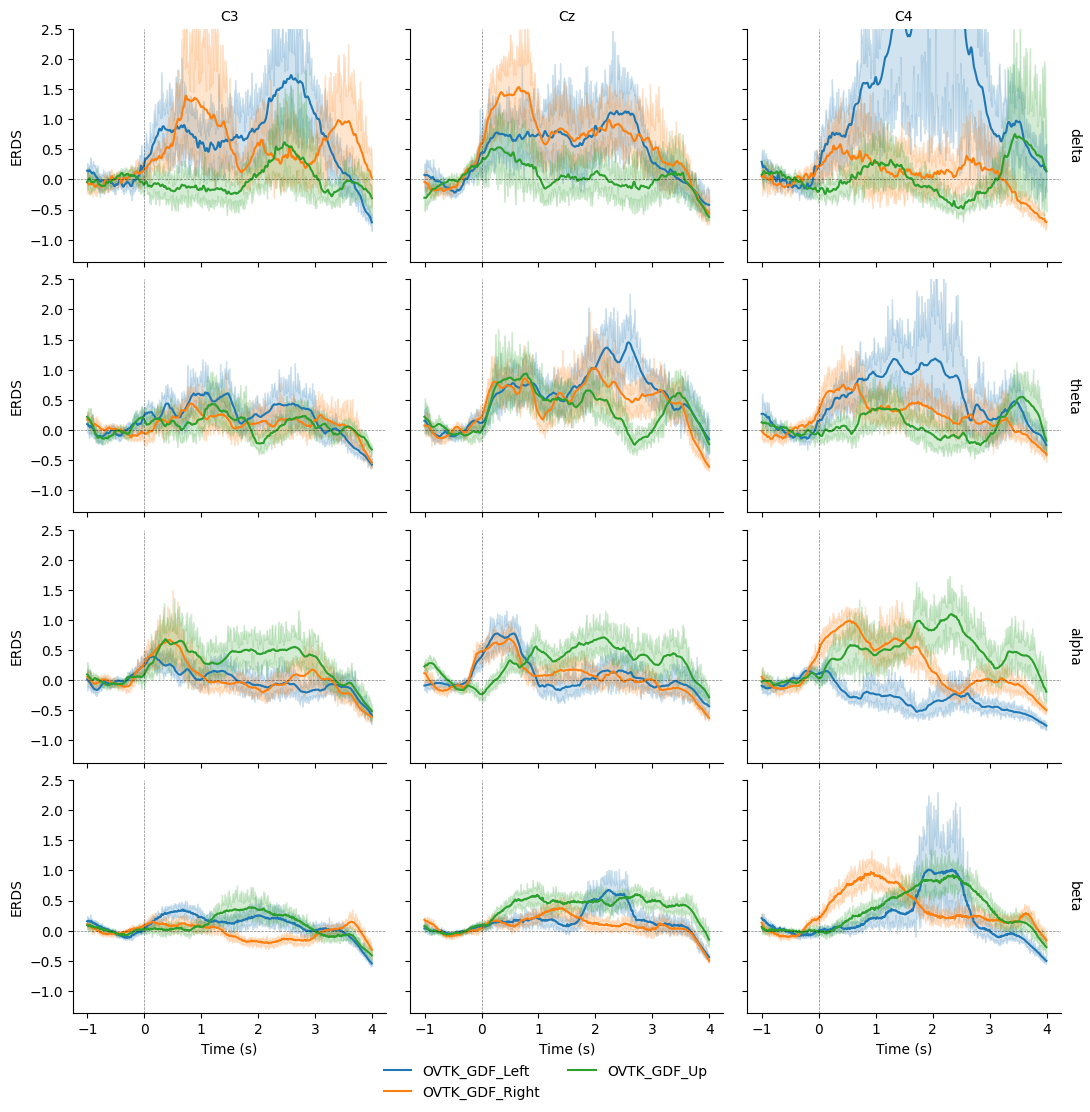

In [20]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 35, "gamma": 140}
df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:
df["channel"] = df["channel"].cat.reorder_categories(("C3", "Cz", "C4"), ordered=True)

g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, vmax))
g.set_axis_labels("Time (s)", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
plt.show()

- CSP

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit,StratifiedKFold ,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

from mne import Epochs, pick_types, events_from_annotations, create_info
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import AverageTFR

In [22]:
eeg3 = raw_edf.copy().filter(l_freq=1.0, h_freq=35.0, method = 'iir', iir_params= {"order": 12, "ftype":'butter'})
eeg3 = eeg3.copy().set_eeg_reference(ref_channels="average")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 48 (effective, after forward-backward)
- Cutoffs at 2.00, 35.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [23]:
events, _ = mne.events_from_annotations(eeg3, event_id=dict(OVTK_GDF_Left=1, OVTK_GDF_Right=2, OVTK_GDF_Up=3))
event_ids = dict(OVTK_GDF_Left=1, OVTK_GDF_Right=2, OVTK_GDF_Up=3)
CSP_epochs = mne.Epochs(eeg3, events,event_ids,
        tmin = -1.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax = 4.0,    # final timestamp (10 means set epoch duration 10 second)
        picks=("Fz","C3", "Cz", "C4","Pz"),
        proj=True,
        preload = True,
        baseline=None,
        event_repeated='drop'
    )
CSP_train = CSP_epochs.copy().crop(tmin=0.0, tmax=2.0)
labels = CSP_epochs.events[:, -1]

Used Annotations descriptions: ['OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Up']
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 1376 original time points ...
0 bad epochs dropped


Computing rank from data with rank=None
    Using tolerance 0.36 (2.2e-16 eps * 5 dim * 3.2e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.58 (2.2e-16 eps * 5 dim * 5.2e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.52 (2.2e-16 eps * 5 dim * 4.7e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.46 (2.2e-16 eps * 5 dim * 4.1e+14  max singular value)
    Estimated rank (mag): 5
   

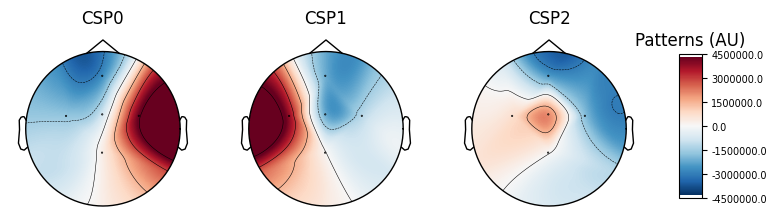

Classification accuracy: 0.816667 / Chance level: 0.666667
[[8 0 2]
 [0 8 2]
 [0 2 8]]


In [24]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
CSP_epochs_data = CSP_epochs.get_data()
CSP_epochs_data_train = CSP_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(CSP_epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=3, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, CSP_epochs_data_train, labels, cv=cv, n_jobs=None)
CSP_predicted = cross_val_predict(clf, CSP_epochs_data_train, labels, cv=5)
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(CSP_epochs_data, labels)

csp.plot_patterns(CSP_epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

conf_matrix = confusion_matrix(labels, CSP_predicted)
print(conf_matrix)


Computing rank from data with rank=None
    Using tolerance 0.36 (2.2e-16 eps * 5 dim * 3.2e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.58 (2.2e-16 eps * 5 dim * 5.2e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.52 (2.2e-16 eps * 5 dim * 4.7e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.46 (2.2e-16 eps * 5 dim * 4.1e+14  max singular value)
    Estimated rank (mag): 5
   

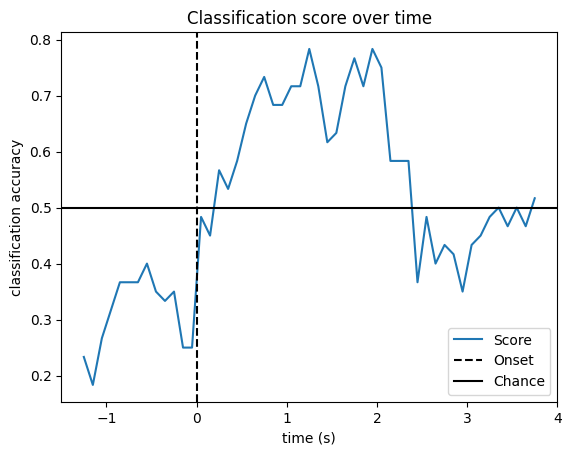

In [25]:
sfreq = eeg3.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, CSP_epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(CSP_epochs_data_train[train_idx], y_train)
    X_test = csp.transform(CSP_epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(CSP_epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + CSP_epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [37]:
# Classification & time-frequency parameters
tmin, tmax = 0.000, 2.000
n_cycles = 10.0  # how many complete cycles: used to define window size
min_freq = 1.0
max_freq = 35.0
n_freqs = 8 # how many frequency bins to use

# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = n_cycles / np.max(freqs) / 2.0
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

# Instantiate label encoder
le = LabelEncoder()

In [38]:
freq_scores = np.zeros((n_freqs - 1,))

# Loop through each frequency range of interest
for freq, (fmin, fmax) in enumerate(freq_ranges):
    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.0)  # in seconds

    # Apply band-pass filter to isolate the specified frequencies
    CSP_filter = raw_edf.copy().filter(
        fmin, fmax, fir_design="firwin", skip_by_annotation="edge"
    )

    # Extract epochs from filtered data, padded by window size
    CSP_epochs2 = Epochs(
        CSP_filter,
        events,
        event_ids,
        tmin - w_size,
        tmax + w_size,
        picks=("Fz","C3", "Cz", "C4","Pz"),
        proj=False,
        baseline=None,
        preload=True,
    )
    # CSP_epochs2.drop_bad()
    y = le.fit_transform(CSP_epochs2.events[:, 2])

    X = CSP_epochs2.get_data()

    # Save mean scores over folds for each frequency and time window
    freq_scores[freq] = np.mean(
        cross_val_score(estimator=clf, X=X, y=y, cv=cv), axis=0
    )

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 6.6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 6.57 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.57 Hz)
- Filter length: 413 samples (1.652 sec)

Not setting metadata
30 matching events found
No baseline correction applied
Using data from preloaded Raw for 30 events and 1667 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 5 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


    Using tolerance 2.4 (2.2e-16 eps * 5 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3 (2.2e-16 eps * 5 dim * 2e+15  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 5 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2 (2.2e-16 eps * 5 dim * 1.8e+15  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


    Using tolerance 0.91 (2.2e-16 eps * 5 dim * 8.2e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.82 (2.2e-16 eps * 5 dim * 7.4e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.7 (2.2e-16 eps * 5 dim * 6.3e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1 (2.2e-16 eps * 5 dim * 9.6e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.83 (2.2e-16 eps * 5 dim * 7.5e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.73 (2.2e-16 eps * 5 dim * 6.6e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.56 (2.2e-16 eps * 5 dim * 5.1e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance usi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.54 (2.2e-16 eps * 5 dim * 4.9e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.49 (2.2e-16 eps * 5 dim * 4.4e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.4 (2.2e-16 eps * 5 dim * 3.6e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance usin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Computing rank from data with rank=None
    Using tolerance 0.43 (2.2e-16 eps * 5 dim * 3.9e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.43 (2.2e-16 eps * 5 dim * 3.8e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.37 (2.2e-16 eps * 5 dim * 3.4e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.41 (2.2e-16 eps * 5 dim * 3.7e+14  max singular value)
    Estimated rank (mag): 5
   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


    Using tolerance 0.31 (2.2e-16 eps * 5 dim * 2.8e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.38 (2.2e-16 eps * 5 dim * 3.4e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.4 (2.2e-16 eps * 5 dim * 3.6e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.34 (2.2e-16 eps * 5 dim * 3.1e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channel

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


    Using tolerance 0.32 (2.2e-16 eps * 5 dim * 2.9e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.26 (2.2e-16 eps * 5 dim * 2.3e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.31 (2.2e-16 eps * 5 dim * 2.8e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.39 (2.2e-16 eps * 5 dim * 3.5e+14  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channe

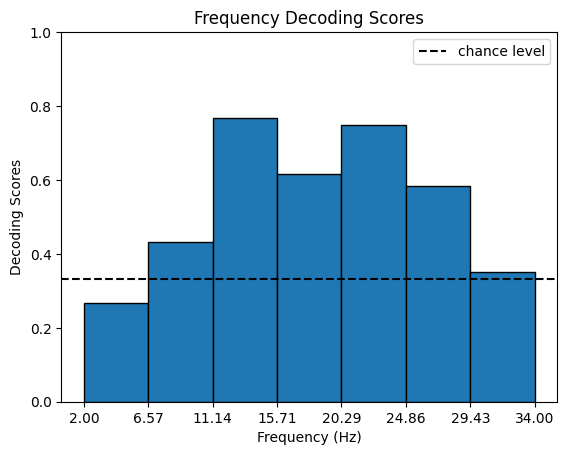

In [39]:
plt.bar(
    freqs[:-1], freq_scores, width=np.diff(freqs)[0], align="edge", edgecolor="black"
)
plt.xticks(freqs)
plt.ylim([0, 1])
plt.axhline(
    len(CSP_epochs2["OVTK_GDF_Up"]) / len(CSP_epochs2), color="k", linestyle="--", label="chance level"
)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Decoding Scores")
plt.title("Frequency Decoding Scores")
plt.show()

- PSD & Power Plot

In [44]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import io
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, source_induced_power

eeg4 = raw_edf.copy().filter(l_freq=1.0, h_freq=35.0, method = 'iir', iir_params= {"order": 12, "ftype":'butter'})
eeg4 = eeg4.copy().set_eeg_reference(ref_channels="average")

events, _ = mne.events_from_annotations(eeg4, event_id=dict(OVTK_GDF_Left=1, OVTK_GDF_Right=2, OVTK_GDF_Up=3))
event_ids = dict(OVTK_GDF_Left=1, OVTK_GDF_Right=2, OVTK_GDF_Up=3)
PSD_epochs = mne.Epochs(eeg4, events,event_ids,
        tmin = -1.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax = 4.0,    # final timestamp (10 means set epoch duration 10 second)
        picks=("Fz","C3", "Cz", "C4","Pz"),
        proj=True,
        preload = True,
        baseline=None,
        event_repeated='drop'
    )


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 48 (effective, after forward-backward)
- Cutoffs at 1.00, 35.00 Hz: -6.02, -6.02 dB



EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Up']
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 1376 original time points ...
0 bad epochs dropped


Effective window size : 1.024 (s)
...
No baseline correction applied


c:\Python311\Lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


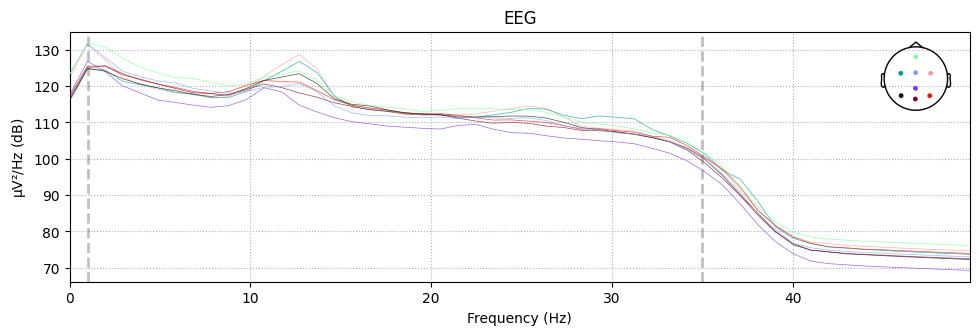

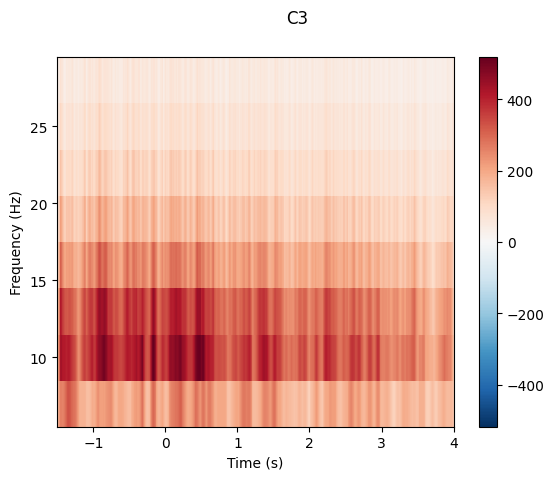

No baseline correction applied


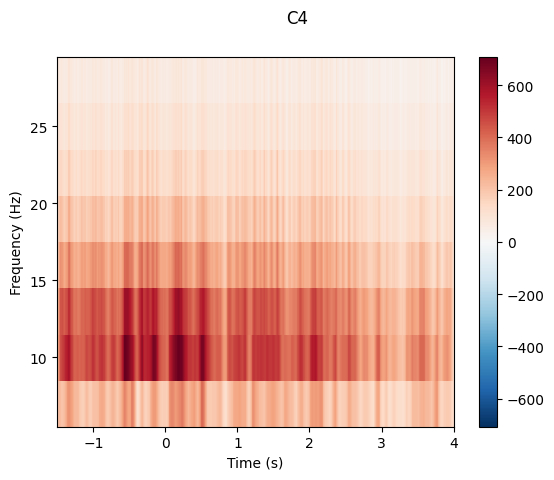

No baseline correction applied


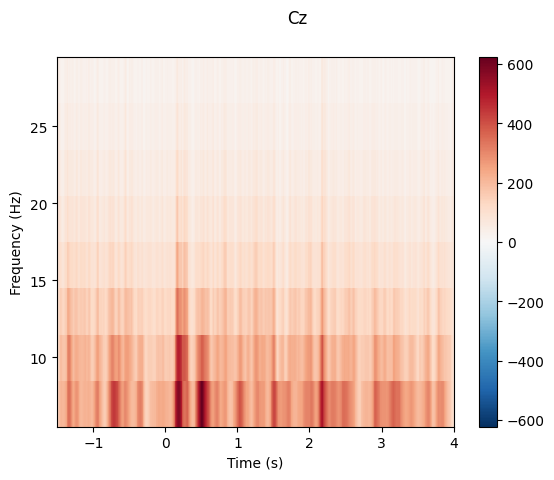

[<Figure size 640x480 with 2 Axes>]

In [55]:
eeg4.compute_psd(fmax=50).plot(picks="data", exclude="bads")
print("...")
frequencies = np.arange(7, 30, 3)
power = mne.time_frequency.tfr_morlet(
    PSD_epochs, n_cycles=2, return_itc=False, freqs=frequencies, decim=3
)
power.plot(picks = "C3", title = "C3")
power.plot(picks = "C4", title = "C4")
power.plot(picks = "Cz", title = "Cz")

- CWT

In [2]:
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from scipy import signal
from scipy import optimize
from pathlib import Path
from IPython.display import Image
from timm.models.layers import conv2d_same
# Generate synthetic data (replace with your own dataset)
# Assuming you have a 2D array 'X' containing your signals and a 1D array 'y' with labels
# X should be of shape (n_samples, signal_length)

# Example:
n_samples = 100
signal_length = 100
n_classes = 2
X = np.random.randn(n_samples, signal_length)
y = np.random.randint(0, n_classes, n_samples)

# Preprocessing: Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the wavelet parameters
wavelet_name = 'morl'  # You can choose a different wavelet

# Perform Continuous Wavelet Transform (CWT)
def compute_cwt(X, wavelet_name):
    global coeffs
    cwt_result = []
    for signal in X:
        coeffs, freq = pywt.cwt(signal, np.arange(1, 50), wavelet_name)
        cwt_result.append(coeffs)
    return np.array(cwt_result)

X_train_cwt = compute_cwt(X_train, wavelet_name)
X_test_cwt = compute_cwt(X_test, wavelet_name)

# Reshape the CWT coefficients
X_train_cwt = X_train_cwt.reshape(X_train_cwt.shape[0], -1)
X_test_cwt = X_test_cwt.reshape(X_test_cwt.shape[0], -1)

# Train a classifier (SVM in this example)
clf = SVC(kernel='linear', C=1.0, random_state=42)
clf.fit(X_train_cwt, y_train)

# Make predictions
y_pred = clf.predict(X_test_cwt)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 45.00%


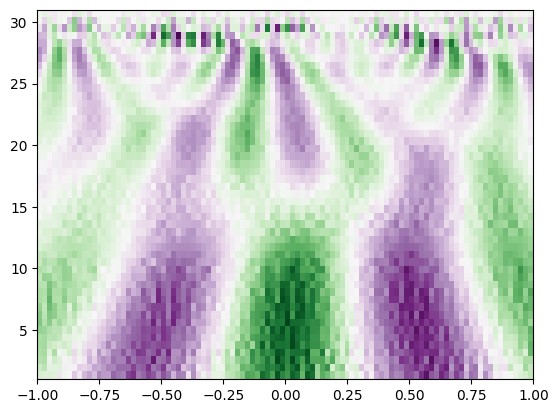

In [3]:
plt.imshow(
    coeffs,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(coeffs).max(),
    vmin=-abs(coeffs).max(),
)

(49, 100)


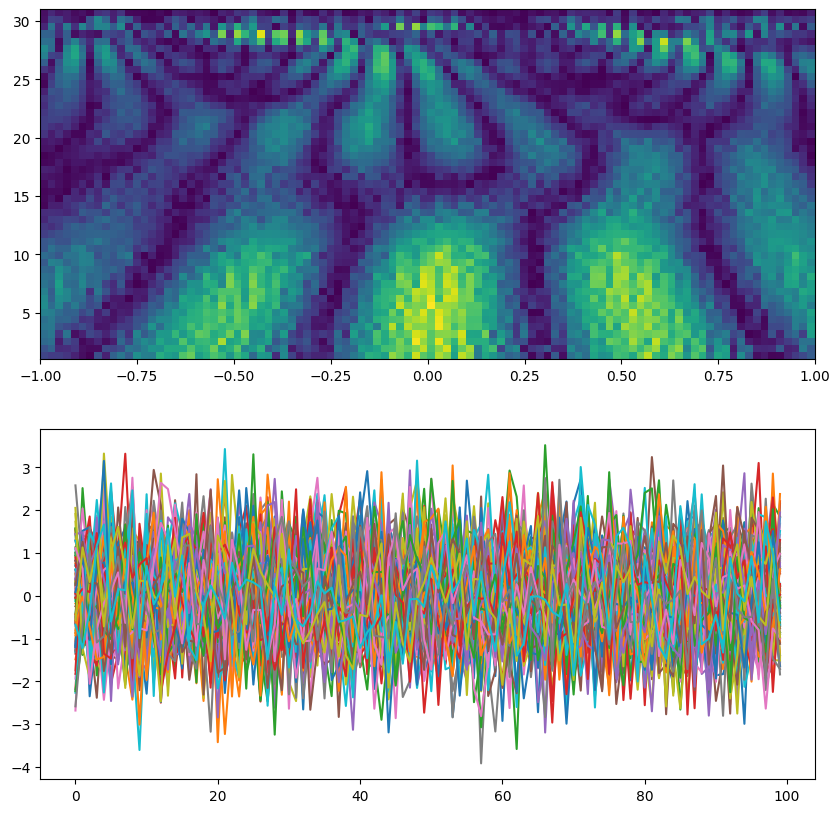

In [4]:
magn = np.absolute(coeffs)
print(magn.shape)
fig, axes = plt.subplots(nrows=2, figsize=(10, 10))
axes[0].imshow(
    magn,
    extent=[-1, 1, 1, 31],
    aspect="auto",
)
axes[1].plot(X)


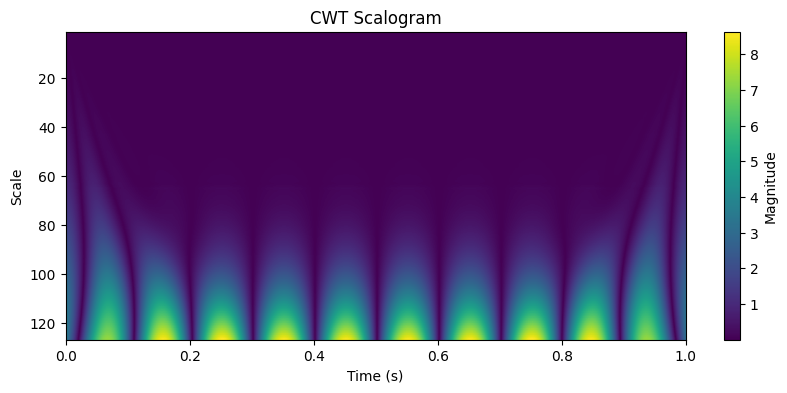

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Generate a sample signal
fs = 1000  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # Time vector
f_signal = 5  # Frequency of the signal (Hz)
signal = np.sin(2 * np.pi * f_signal * t)


# Define the wavelet and scales
wavelet = 'morl'  # You can choose a different wavelet
scales = np.arange(1, 128)  # Adjust the scales as needed

# Compute the Continuous Wavelet Transform (CWT)
cwtmatr, _ = pywt.cwt(signal, scales, wavelet)

# Create the CWT scalogram image
plt.figure(figsize=(10, 4))
plt.imshow(np.abs(cwtmatr), extent=[0, 1, scales[-1], scales[0]], cmap='viridis', aspect='auto')
plt.colorbar(label='Magnitude')
plt.title('CWT Scalogram')
plt.xlabel('Time (s)')
plt.ylabel('Scale')
plt.show()

- STFT

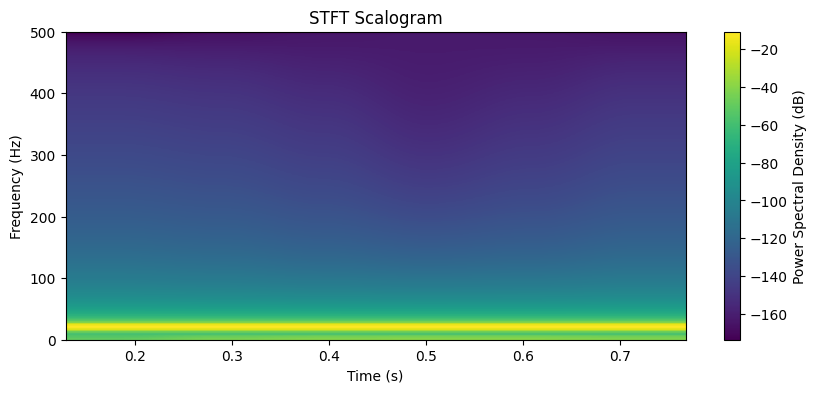

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Generate a sample signal
fs = 1000  # Sampling frequency (Hz)
t = np.linspace(0, 2,fs, endpoint=False)  # Time vector
f_signal = 10  # Frequency of the signal (Hz)
signal = np.sin(2 * np.pi * f_signal * t)

# Compute the Short-Time Fourier Transform (STFT)
frequencies, times, Sxx = spectrogram(signal, fs=fs, nperseg=256, noverlap=128, window='hann')

# Create the STFT scalogram image
plt.figure(figsize=(10, 4))
plt.imshow(10 * np.log10(Sxx), origin='lower', cmap='viridis', aspect='auto', extent=[times.min(), times.max(), frequencies.min(), frequencies.max()])
plt.colorbar(label='Power Spectral Density (dB)')
plt.title('STFT Scalogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()